## Example -- Taylor 2023

Example of using `optiwindnet` for routing the cables of a wind farm location with 122 turbines and 2 substations, which has a concave cable-laying area and one obstacle within that area.

Additional complexity on the geometry of the location has negligible impact on the solving time, as it does not increase the number of variables in the MILP model.

In [1]:
import pyomo.environ as pyo

In [2]:
from optiwindnet.api import WindFarmNetwork, Heuristic, MILP

topology in {"radial", "branched"}
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented"}
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3"}
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.



### Solvers

Using a MILP solver can produce better solutions. This notebook uses COIN-OR CBC but examples for other solvers can be found in the *MILP* notebooks.

There are some differences in solver parameters even for the ones supported through pyomo.

Gurobi and IBM ILOG CPLEX are comercial solvers (academic license available). Google's OR-Tools, COIN-OR CBC, SCIP and HiGHS are open-source software.

In [3]:
cbcer = pyo.SolverFactory('cbc')
cbcer.available(), type(cbcer)

(True, pyomo.solvers.plugins.solvers.CBCplugin.CBCSHELL)

### Load input data

In [4]:
file_path = '../../optiwindnet/data/Taylor-2023.yaml'
wfn = WindFarmNetwork.from_yaml(filepath=file_path, cables=7, verbose=True)

Using example location from <https://onlinelibrary.wiley.com/doi/abs/10.1049/rpg2.12593>.

In [5]:
print(wfn.L)

Graph named 'Taylor-2023' with 124 nodes and 0 edges


In [6]:
print(wfn.L.graph)

{'T': 122, 'R': 2, 'B': 18, 'VertexC': array([[9.1620e+03, 8.8660e+03],
       [9.7510e+03, 8.3600e+03],
       [1.0366e+04, 7.7490e+03],
       [6.8400e+03, 1.0077e+04],
       [7.4170e+03, 9.5600e+03],
       [8.0120e+03, 8.9560e+03],
       [8.5490e+03, 8.3690e+03],
       [9.1200e+03, 7.7150e+03],
       [9.7140e+03, 7.1720e+03],
       [5.6440e+03, 1.0171e+04],
       [6.2310e+03, 9.5840e+03],
       [6.8020e+03, 8.9790e+03],
       [7.3840e+03, 8.3750e+03],
       [7.9060e+03, 7.7560e+03],
       [8.5390e+03, 7.1390e+03],
       [3.8810e+03, 1.0694e+04],
       [4.4910e+03, 1.0176e+04],
       [5.0610e+03, 9.5960e+03],
       [5.6280e+03, 8.9860e+03],
       [6.2270e+03, 8.3890e+03],
       [6.8100e+03, 7.7770e+03],
       [7.9670e+03, 6.6070e+03],
       [2.6900e+03, 1.0802e+04],
       [3.2730e+03, 1.0211e+04],
       [3.8350e+03, 9.6000e+03],
       [4.4120e+03, 9.0180e+03],
       [4.9900e+03, 8.4450e+03],
       [5.5940e+03, 7.8670e+03],
       [6.1900e+03, 7.2700e+03],
    

Note: To view SVG cell outputs, trust this notebook first.

<Axes: >

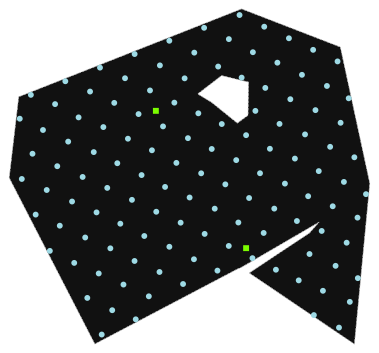

In [7]:
# set Matplotlib option to generate inline SVG
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'

# plot location
wfn.plot_location()

<Axes: >

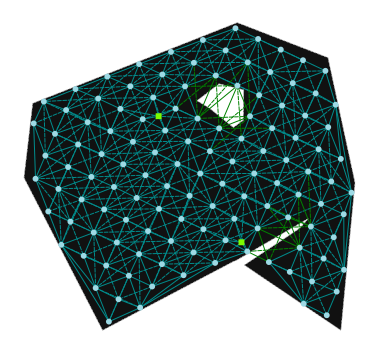

In [8]:
wfn.plot_available_links()

<Axes: >

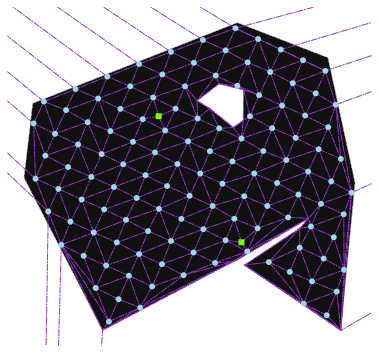

In [9]:
wfn.plot_navigation_mesh()

When the location has more than one substation, we cannot use the *HGS-CVRP* meta-heuristic. Instead, we may use a very fast heuristic: *Esau-Williams presolver* (**EW_presolver**).

**EW_presolver** has the downside of not limiting the number of feeders, thus the model to be warm-started must also have an unlimited number of feeders. This is usually not a problem, as most cable route sets produced by the MILP solver use the minimum number of feeders or only one more than the minimum.

### Generate the warm-start solution

In [10]:
router_warmstart = Heuristic(solver='Esau_Williams')
res_warmstart= wfn.optimize(router=router_warmstart)

### Visualizing the warm-start solution

This section is unecessary in production.

S which contains selected links is used for warmstart (not final graph which is stored in G). S can be visualized using wfn.plot_selected_links()

<Axes: >

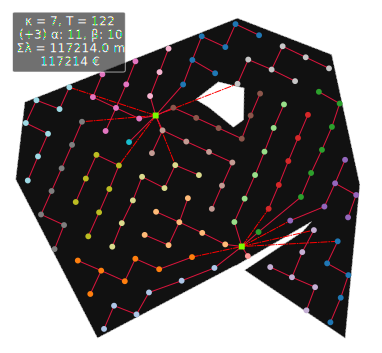

In [11]:
wfn.plot_selected_links()

### Create MILP model and optimize it

In [12]:
cbcer = pyo.SolverFactory('cbc')
cbcer.available(), type(cbcer)

(True, pyomo.solvers.plugins.solvers.CBCplugin.CBCSHELL)

In [13]:
solver_options=dict(
    ratioGap=0.005,
    seconds=300,
    timeMode='elapsed',
    threads=8,
    # if repeatable results are desired, set the seed
    RandomCbcSeed=4321,
    # the parameters below and more can be experimented with
    # http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf
    nodeStrategy='downFewest',
    # Heuristics
    Dins='on',
    VndVariableNeighborhoodSearch='on',
    pivotAndComplement='on',
    Rens='on',
    Rins='on',
    proximitySearch='off',
    # Cuts
    gomoryCuts='on',
    mixedIntegerRoundingCuts='on',
    flowCoverCuts='on',
    cliqueCuts='off',
    twoMirCuts='off',
    knapsackCuts='off',
    probingCuts='off',
    zeroHalfCuts='off',
    liftAndProjectCuts='off',
    residualCapacityCuts='off',
)


model_options = {"gateXing_constraint": False,
                 "branching": True,
                 "gates_limit": False}

router = MILP(solver='cbc', solver_options=solver_options, model_options=model_options)
res = wfn.optimize(router=router)

load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\ortools.dll...


TypeError: make_min_length_model() got an unexpected keyword argument 'gateXing_constraint'

In [ ]:
print(res)

[  6   0   1  10   3  -2   5  14   7  10  11  20  -2  12  13  16  17  18
  19  29  -2  14  31  15  25  26  27  28  -2  -2  -2  41  42  34  35  36
  37  38  -2  -2  -2  42  53  44  45  55  56  46  47  39  -2  40  64  54
  -1  67  68  69  59  49  59  50  51  62  65  77  78  80  81  -1  69  59
  60  61  73  63  75  78  79  -1  -1  -1  81  70  83  84  85  74  87  90
  91  -1  -1  -1  -1  94  95  96  87 100 101  92 101  94 103 104 114 106
 109 101  -1 110 111 112 113  -1 115 121 117 118 116 120]


<Axes: >

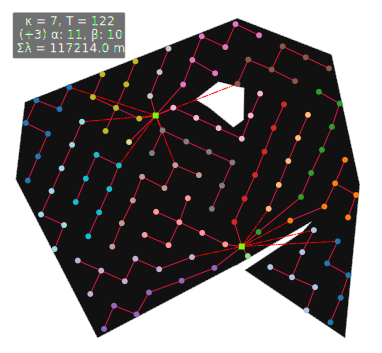

In [ ]:
wfn.plot_selected_links()

### Trace routes from solution topology

<Axes: >

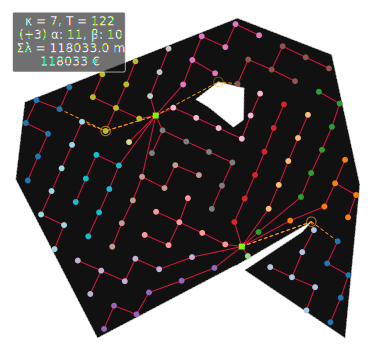

In [ ]:
wfn.plot()

In [ ]:
wfn.get_network_array()

array([( 67,  80,  814.70976427, 5.,  True, 0,  814.70976427),
       ( 67,  55,  800.03812409, 4.,  True, 0,  800.03812409),
       ( 80,  -1,  627.35157607, 6., False, 0,  627.35157607),
       ( 55,  45,  829.7644244 , 3.,  True, 0,  829.7644244 ),
       ( 68,  56,  811.31066799, 4.,  True, 0,  811.31066799),
       ( 68,  81,  854.85905271, 5.,  True, 0,  854.85905271),
       ( 81,  -1,  531.58818648, 7., False, 0,  531.58818648),
       ( 81,  82,  817.17378813, 1., False, 0,  817.17378813),
       ( 56,  46,  834.65561761, 3.,  True, 0,  834.65561761),
       ( 99, 100,  807.7252008 , 1.,  True, 0,  807.7252008 ),
       (100, 101,  834.42914618, 2.,  True, 0,  834.42914618),
       (101,  92,  830.53356344, 6., False, 0,  830.53356344),
       (101, 109,  829.2611169 , 2., False, 0,  829.2611169 ),
       (101, 102,  823.96905282, 1., False, 0,  823.96905282),
       ( 18,  17,  832.8199085 , 4.,  True, 0,  832.8199085 ),
       ( 18,  19,  845.70089275, 5.,  True, 0,  845.700